This Notebook/demo uses spike interface, [here is how to install Spike Interface](https://spikeinterface.readthedocs.io/en/latest/installation.html)

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import Extract_raw_data as erd
import numpy as np 

## Load Data & get good units

Spike Interface can load in many different types of Ephys data look [here](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html) for documentation on fucntion to read in different data formats. 

In [2]:
#Make list of recordings/sortings to iterate over
Recordings = [se.read_spikeglx(r'path/to/SpikeGLX/data', stream_name="imec0.ap")]

Sortings = [se.read_kilosort(r'Path/To/KiloSort/Directory')]

#Will only make average wavefroms for good units
ExtractGoodUnitsOnly = True

In [3]:
#Getting good units only
Sortings[0].get_property_keys() #lists keys for attached propties if 'quality' is not suitbale

#Good units which will be used in Unit Match
GoodUnits = []
UnitsUsed = []
for i, sorting in enumerate(Sortings):
    UnitIdsTmp = sorting.get_property('original_cluster_id')
    IsGoodTmp = sorting.get_property('quality')
    GoodUnits.append(np.stack((UnitIdsTmp,IsGoodTmp), axis = 1))

    UnitsUsed.append(UnitIdsTmp)
    if ExtractGoodUnitsOnly is True:
        keep = np.argwhere(IsGoodTmp == 'good').squeeze()
        Sortings[i] = sorting.select_units(keep)
        


## Process average waveforms / templates

Beaware the spike interface method is different to the native unitmatch method in ExtractRawDemo.ipynb or in the MatLab version

In [5]:
# # Preprocces the raw data
for recording in Recordings:
    recording = spre.phase_shift(recording) #correct for time delay between recording channels
    recording = spre.highpass_filter(recording) #highpass

    # for motion correction, this can be very slow
    #Uncommented code below to do in session motion correction
    #recording = spre.correct_motion(recording, preset="nonrigid_fast_and_accurate")

detect and localize:   0%|          | 0/1969 [00:00<?, ?it/s]

c:\Users\Experiment\AppData\Local\Programs\Python\Python311\Lib\site-packages\spikeinterface\sortingcomponents\motion_estimation.py:1445: RuntimeWarning: invalid value encountered in divide
  corr /= npx.sqrt(var_template)
c:\Users\Experiment\AppData\Local\Programs\Python\Python311\Lib\site-packages\spikeinterface\sortingcomponents\motion_estimation.py:1444: RuntimeWarning: invalid value encountered in divide
  corr /= npx.sqrt(var_x)


In [6]:
#Split each recording/sorting into 2 halves                    
for i, sorting in enumerate(Sortings):
    SplitIdx = Recordings[i].get_num_samples() // 2

    SplitSorting = []
    SplitSorting.append(sorting.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitSorting.append(sorting.frame_slice(start_frame=SplitIdx, end_frame=Recordings[i].get_num_samples()))

    Sortings[i] = SplitSorting 

for i, recording in enumerate(Recordings):
    SplitIdx = recording.get_num_samples() // 2

    SplitRecording = []
    SplitRecording.append(recording.frame_slice(start_frame=0, end_frame=SplitIdx))
    SplitRecording.append(recording.frame_slice(start_frame=SplitIdx, end_frame=recording.get_num_samples()))

    Recordings[i] = SplitRecording
 

In [7]:
#create sorting analyzer for each pair
Analysers = []
for i in range(len(Recordings)):
    SplitAnalysers = []

    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][0], Recordings[i][0], sparse=False))
    SplitAnalysers.append(si.create_sorting_analyzer(Sortings[i][1], Recordings[i][1], sparse=False))
    Analysers.append(SplitAnalysers)

In [8]:
#create the fast tempalte extension for each sorting analyser
AllWaveforms = []
for i in range(len(Analysers)):
    for half in range(2):
        Analysers[i][half].compute(
            "random_spikes",
            method="uniform",
            max_spikes_per_unit=500)
        
        #Analysers[i][half].compute('fast_templates', n_jobs = 0.8,  return_scaled=True)
        Analysers[i][half].compute('fast_templates', n_jobs = 0.8)
    
    TemplatesFirst = Analysers[i][0].get_extension('fast_templates')
    TemplatesSecond = Analysers[i][1].get_extension('fast_templates')
    t1 = TemplatesFirst.get_data()
    t2 = TemplatesSecond.get_data()
    AllWaveforms.append(np.stack((t1,t2), axis = -1))

#Make a channel_postions array
AllPositions = []
for i in range(len(Analysers)):
    #postions for first half and second half are the same
    AllPositions.append(Analysers[i][0].get_channel_locations())

estimate_templates_average:   0%|          | 0/985 [00:00<?, ?it/s]

estimate_templates_average:   0%|          | 0/985 [00:00<?, ?it/s]

## Save extracted data in a unit match friendly folder

In [9]:
import os
UMInputDir = os.path.join(os.getcwd(), 'UMInputData')

os.mkdir(UMInputDir)

AllSessionPaths = []
for i in range(len(Recordings)):
    SessionXpath = os.path.join(UMInputDir, f'Session{i+1}') #lets start at 1
    os.mkdir(SessionXpath)

    #save the GoodUnits as a .rsv first column is unit ID,second is 'good' or 'mua'
    GoodUnitsPath = os.path.join(SessionXpath, 'cluster_group.tsv')
    ChannelPositionsPath = os.path.join(SessionXpath, 'channel_positions.npy')
    SaveGoodUnits = np.vstack((np.array(('cluster_id', 'group')), GoodUnits[i])) #Title of colum one is '0000' Not 'cluster_id')
    SaveGoodUnits[0,0] = 0 # need to be int to use np.savetxt 
    np.savetxt(GoodUnitsPath, SaveGoodUnits, fmt =['%d','%s'], delimiter='\t')
    if ExtractGoodUnitsOnly:
        Units = np.argwhere(GoodUnits[0][:,1] == 'good')
        erd.Save_AvgWaveforms(AllWaveforms[i], SessionXpath, Units, ExtractGoodUnitsOnly = ExtractGoodUnitsOnly)
    else:
        erd.Save_AvgWaveforms(AllWaveforms[i], SessionXpath, GoodUnits[i], ExtractGoodUnitsOnly = ExtractGoodUnitsOnly)
    np.save(ChannelPositionsPath, AllPositions[i])

    AllSessionPaths.append(SessionXpath)

## Run UnitMatch

In [10]:
%load_ext autoreload
%autoreload 
import Bayes_fun as bf
import utils as util
import Overlord
import numpy as np
import matplotlib.pyplot as plt
import GUI as gui
import Save_utils as su

In [11]:
#get default parameters, can add your own before or after!

# default of Spikeinterface as by default spike interface extracts waveforms in a different manner.
param = {'SpikeWidth': 90, 'waveidx': np.arange(20,50), 'PeakLoc': 35}
param = util.get_default_param(param)

WavePaths, UnitLabelPaths, ChannelPos = util.paths_fromKS(AllSessionPaths)

In [12]:
def zero_center_waveform(waveform):
    """
    Centers waveform about zero, by subtracting the mean of the first 15 time points.
    This function is useful for Spike Interface where the waveforms are not centered about 0.

    Arguments:
        waveform - ndarray (nUnits, Time Points, Channels, CV)

    Returns:
        Zero centered waveform
    """
    waveform = waveform -  np.broadcast_to(waveform[:,:15,:,:].mean(axis=1)[:, np.newaxis,:,:], waveform.shape)
    return waveform

In [13]:
#read in data and select the good units and exact metadata
waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above

#Recenter the waveform at 0, as is not part of spike interface tempaltes 
waveform = zero_center_waveform(waveform)

# create clusInfo, contains all unit id/session related info
ClusInfo = {'GoodUnits' : GoodUnits, 'SessionSwitch' : SessionSwitch, 'SessionID' : SessionID, 
            'OriginalID' : np.concatenate(GoodUnits) }

#Extract parameters from waveform
ExtractedWaveProperties = Overlord.extract_parameters(waveform, ChannelPos, ClusInfo, param)

#Extract metric scores
TotalScore, CandidatePairs, Scores2Include, Predictors  = Overlord.extract_metric_scores(ExtractedWaveProperties, SessionSwitch, WithinSession, param, niter  = 2)

#Probability analysis
priorMatch = 1 - (param['nExpectedMatches'] / param['nUnits']**2 ) # fredom of choose in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['nUnits'],param['nUnits'])

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:221: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


The percentage of units matched to themselves is: 94.24460431654677%
The percentage of false -ve's then is: 5.75539568345323% 

The rate of miss-match(es) per expected match 0.07913669064748201
The percentage of false +ve's is 0.028569202399813004% for session 1

This assumes that the spike sorter has made no mistakes


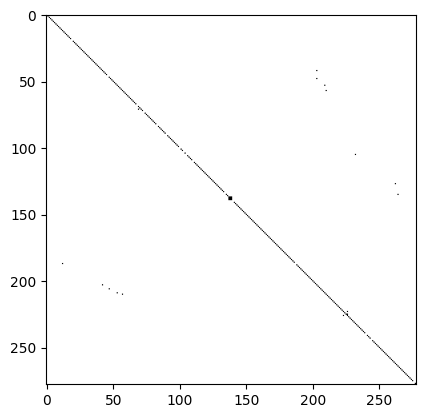

In [20]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, MatchThreshold = 0.75)

MatchThreshold = 0.75
OutputThreshold = np.zeros_like(Output)
OutputThreshold[Output > MatchThreshold] = 1

plt.imshow(OutputThreshold, cmap = 'Greys')


In [21]:
Amplitude = ExtractedWaveProperties['Amplitude']
SpatialDecay = ExtractedWaveProperties['SpatialDecay']
AvgCentroid = ExtractedWaveProperties['AvgCentroid']
AvgWaveform = ExtractedWaveProperties['AvgWaveform']
AvgWaveformPerTP = ExtractedWaveProperties['AvgWaveformPerTP']
WaveIdx = ExtractedWaveProperties['WaveIdx']
MaxSite = ExtractedWaveProperties['MaxSite']
MaxSiteMean = ExtractedWaveProperties['MaxSiteMean']
gui.process_info_for_GUI(Output, MatchThreshold, Scores2Include, TotalScore, Amplitude, SpatialDecay,
                         AvgCentroid, AvgWaveform, AvgWaveformPerTP, WaveIdx, MaxSite, MaxSiteMean, 
                         waveform, WithinSession, ChannelPos, ClusInfo, param)


In [23]:
IsMatch, NotMatch, MatchesGUI = gui.run_GUI()

In [ ]:
Matches = np.argwhere(MatchThreshold == 1)

SaveDir = r'Path/to/save/directory'
su.save_to_output(SaveDir, Scores2Include, Matches, Output, AvgCentroid, AvgWaveform, AvgWaveformPerTP, MaxSite,
                   TotalScore, OutputThreshold, ClusInfo, param, MatchesCurated = None, SaveMatchTable = True)